In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        # （batch,1,28,28）
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3), #（batch,32,26,26） 输入通道数1输出通道数32 32为小型任务的经验性选择，一般每层增加一倍欠拟合就加过拟合减
            torch.nn.BatchNorm2d(32), # 对卷积层的输出进行批量归一化，使得每个特征图的分布更加稳定，从而加速训练并提高模型性能。
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,32,13,13）
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3), #（batch,64,11,11）
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,64,5,5）
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1600, 50), # 1600 == 64*5*5
            torch.nn.ReLU(),  # 添加ReLU激活函数 增加模型的非线性能力
            torch.nn.Dropout(0.5), # 有效防止过拟合-丢弃率0.5          BN层和dropout层一起用效果不好（ 深层可能不好BN在后Dropout在前也不好
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [4]:
model = Net().to(device)

model_path = '../models/1_Handwritten_Digit_Recognition/model_weights.pth'

# 加载模型参数
model.load_state_dict(torch.load(model_path))

# 将模型设置为评估模式
model.eval()

C:\Users\PC\AppData\Local\Temp\ipykernel_17584\457276358.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [5]:
# 预测函数
def predict_image(image_path, model):
    image = Image.open(image_path)
    # 图像预处理
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 转换为灰度
        transforms.Resize((28, 28)),                 # 调整到 28x28
        transforms.ToTensor(),                       # 转换为张量
        transforms.Normalize((0.5,), (0.5,))         # 归一化到 [-1, 1]
    ])
    image = transform(image)
    image = image.to(device)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()

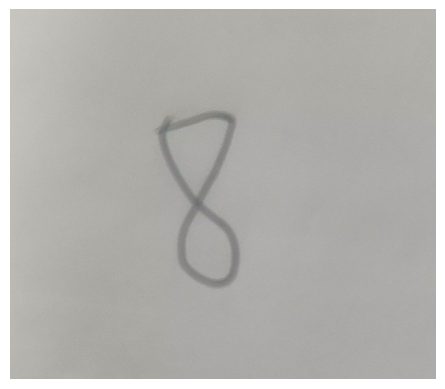

Predicted digit: 8


In [6]:
#展示图片

import matplotlib.pyplot as plt
img = Image.open('./data/8.png')

# 显示图像
plt.imshow(img)
plt.axis('off')  # 可选，关闭坐标轴
plt.show()


# 使用模型进行预测
predicted_digit = predict_image('./data/8.png', model)
print(f"Predicted digit: {predicted_digit}")